In [1]:
!pip install datasets
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 27.2 MB/s eta 0:00:00


In [19]:
import sys
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datasets import Dataset
from PIL import Image
import pandas as pd
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from PIL import Image
import tensorflow as tf
import numpy as np
import io
import os

In [20]:
from google.colab import drive
drive.mount('/content/drive/',force_remount = True)

Mounted at /content/drive/


In [21]:
dataset_path ='/content/drive/MyDrive/Colab-Notebooks/Grayscale_images'
dataset_path_test ='/content/drive/MyDrive/Colab-Notebooks/images/test'
validation_split = 0.1  # adjust this value as needed

ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels=None,
    label_mode=None,
    class_names=None,
    image_size=(180, 180),
    batch_size=8,
    shuffle=False,
    seed=None,
    validation_split=validation_split,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
)

ds_validation = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels=None,
    label_mode=None,
    class_names=None,
    image_size=(180, 180),
    batch_size=8,
    shuffle=False,
    seed=None,
    validation_split=validation_split,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    dataset_path_test,
    labels=None,
    label_mode=None,
    class_names=None,
    image_size=(180, 180),
    batch_size=8,
    shuffle=False,
    seed=None,
    interpolation='bilinear',
    follow_links=False,
)



Found 500 files belonging to 1 classes.
Using 450 files for training.
Found 500 files belonging to 1 classes.
Using 50 files for validation.
Found 100 files belonging to 1 classes.


In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

def rgb_to_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image

def normalize_img(image):
  return tf.cast(image,tf.float32)/255.0

def resize(img):
    return tf.image.resize_with_crop_or_pad(img, 180, 180)

BATCH_SIZE = 8
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Cardinality before processing: {tf.data.experimental.cardinality(ds_train).numpy()}')

ds_train = ds_train.map(rgb_to_grayscale)  # First convert to grayscale
ds_validation = ds_validation.map(rgb_to_grayscale)
ds_test = ds_test.map(rgb_to_grayscale)
ds_train = ds_train.map(resize)  # Then resize
ds_validation= ds_validation.map(resize)
ds_test = ds_test.map(resize)
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)  # Finally normalize
ds_validation = ds_validation.map(normalize_img, num_parallel_calls = AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls = AUTOTUNE)
#ds_train = ds_train.map(extract_patches)
ds_train = ds_train.shuffle(1000)
ds_validation = ds_validation.shuffle(1000)
ds_test = ds_test.shuffle(1000)
ds_train = ds_train.prefetch(AUTOTUNE)
ds_validation= ds_validation.prefetch(AUTOTUNE)
ds_test = ds_test.prefetch(AUTOTUNE)


Num GPUs Available:  1
Cardinality before processing: 57


In [23]:
def psnr(y_true,y_pred):
  return tf.image.psnr(y_true,y_pred,max_val=1)

def ssim(y_true,y_pred):
  return tf.image.ssim(y_true,y_pred,max_val=1)

In [ ]:
class SharpeningLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SharpeningLayer, self).__init__(**kwargs)

        # Create the identity filter, but with the 1 shifted to the right!
        kernel = np.zeros((3,3))
        kernel[1,1] = 2

        # Create a box filter:
        boxFilter = np.ones((3,3)) / 9.0

        # Subtract the two:
        self.kernel = tf.constant(kernel - boxFilter, dtype=tf.float32)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)
        self.kernel = tf.expand_dims(self.kernel, axis=-1)

    def call(self, inputs):
        return tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

In [24]:
#BATCH_SIZE=8
# %%
CHANNELS = 1
HEIGHT =180
WIDTH=180

class SystemCNN():
  def __init__(self, input_shape):
    w, h, c = input_shape
    self.width = w
    self.height = h
    self.channels = c
    self.comp_cnn_out_shape = []

  def CompCNN(self):
    input_shape = (self.width, self.height, self.channels)
    x = layers.Input(input_shape)
    print(input_shape) # input_shape=(300,300,3)
    out = layers.Conv2D(64, kernel_size=3, strides=1,padding="same")(x)
    out = layers.Activation('relu')(out)
    out = layers.Conv2D(64, kernel_size=3, strides = 2, padding = "same")(out)
    #out = layers.BatchNormalization()(out)
    out = layers.Activation('relu')(out)
    out = layers.Conv2D(self.channels, kernel_size = 3, strides=1, padding = "same")(out)
    print(out.shape)
    self.comp_cnn_out_shape = out.shape.as_list()[1:]
    return tf.keras.Model(x, out, name='comp_cnn')

  def RecCNN(self):
    if len(self.comp_cnn_out_shape) != 3:
      input_shape = (89,89,3)
    else:
      input_shape = self.comp_cnn_out_shape

    x = layers.Input(input_shape) # input_shape=(149,149,3)
    upscaled_image = layers.Resizing(180, 180, 'bicubic')(x)

    #first Layer
    out = layers.Conv2D(64, kernel_size=3, strides=1,padding="same")(upscaled_image)
    out = layers.Activation('relu')(out)
    #2nd to 19th layer
    for i in range(0,19):
      out = layers.Conv2D(64, kernel_size=3,strides = 1,padding="same")(out)
      #out = layers.BatchNormalization()(out)
      out = layers.Activation('relu')(out)
    #Final Layer
    residual_image = layers.Conv2DTranspose(self.channels, kernel_size=3, strides=1,padding = "same")(out)
    #residual_image = SharpeningLayer()(residual_image)
    #residual_image = layers.Activation("relu")(residual_image)
    final = layers.Add()([upscaled_image, residual_image])
    return tf.keras.Model(x, [final,residual_image,upscaled_image])

In [ ]:
# %%
quality_values = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
steps_per_epoch = 450/8
model = SystemCNN((WIDTH, HEIGHT, CHANNELS))
model_CompCNN = model.CompCNN()
model_RecCNN = model.RecCNN()
# model.RecCNN((149,149,3)).summary()
lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=steps_per_epoch,
    decay_rate=0.91,
    staircase=True)
lr_schedule2 = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=steps_per_epoch,
    decay_rate=0.87,
    staircase=True)
# %%
# Instantiate an optimizer.
optimizer_CompCnn = tf.keras.optimizers.Adam(learning_rate=lr_schedule1)
optimizer_RecCnn = tf.keras.optimizers.Adam(learning_rate=lr_schedule2)
optimizer_CompCnn.build(model_CompCNN.trainable_weights)
optimizer_RecCnn.build(model_RecCNN.trainable_weights)
# Instantiate a loss function.
loss_fn1 = keras.losses.MeanSquaredError() # Comp: input, final
loss_fn2 = keras.losses.MeanSquaredError() # Rec: out,input - upscaled_image
# Instantiate a loss function.




# %%
def codec(x, quality):
    #print("Original min and max:", tf.reduce_min(x), tf.reduce_max(x))
    # Scale to [0,255]
    x = tf.cast(x*255, tf.uint8)
    #print("Scaled min and max:", tf.reduce_min(x), tf.reduce_max(x))
    # Encode with encode_jpeg. It returns the values in string array
    x_enc = tf.map_fn(fn=lambda t: tf.io.encode_jpeg(t, quality=quality, format='grayscale'), elems=x, dtype=tf.string)
    # Decode
    x_dec = tf.map_fn(fn=lambda t: tf.io.decode_jpeg(t, channels=1), elems=x_enc, dtype=tf.uint8)
    #print("Decoded min and max:", tf.reduce_min(x_dec), tf.reduce_max(x_dec))
    x = tf.cast(x_dec, tf.float32)
    # Rescale to [0,1]
    x = x/255.0
    #print("Final min and max:", tf.reduce_min(x), tf.reduce_max(x))
    return x


# %%
batch_size = 8
epochs = 20

for quality in quality_values:
  print(f"\nTraining for quality={quality}")
  print("Initializing the model again")
  model = SystemCNN((180, 180, 1))
  model_CompCNN = model.CompCNN()
  model_RecCNN = model.RecCNN()
  #steps_per_epoch = 256000 / batch_size #2000
  steps_per_epoch = 450/8
  lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(
      0.0001,
      decay_steps=steps_per_epoch,
      decay_rate=0.91,
      staircase=True)
  lr_schedule2 = tf.keras.optimizers.schedules.ExponentialDecay(
      0.001,
      decay_steps=steps_per_epoch,
      decay_rate=0.87,
      staircase=True)
  # %%
  # Instantiate an optimizer.
  optimizer_CompCnn = tf.keras.optimizers.Adam(learning_rate=lr_schedule1)
  optimizer_RecCnn = tf.keras.optimizers.Adam(learning_rate=lr_schedule2)
  # Instantiate a loss function.
  loss_fn1 = keras.losses.MeanSquaredError() # Comp: input, final
  loss_fn2 = keras.losses.MeanSquaredError() # Rec: out,input - upscaled_image
  for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(ds_train):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Update RecCNN - Eq(5)
            comp_img = model_CompCNN(x_batch_train, training=False)
            xm = codec(comp_img,quality)
            o_rec_img, o_residual, o_upscaled_image = model_RecCNN(xm, training=True)
            # Compute the loss value for this minibatch - Eq(5).
            rec_residual = o_residual  # the learned residual
            true_residual = -o_upscaled_image + x_batch_train  # the true residual
            loss_value2 = loss_fn2(true_residual, rec_residual)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value2, model_RecCNN.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer_RecCnn.apply_gradients(zip(grads, model_RecCNN.trainable_weights))



        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Update CompCNN - Eq(13)
            comp_img = model_CompCNN(x_batch_train, training=True)
            o_rec_img, o_residual, o_upscaled_image = model_RecCNN(comp_img, training=False)
            # Compute the loss value for this minibatch - Eq(13).
            loss_value1 = loss_fn1(x_batch_train, o_rec_img)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value1, model_CompCNN.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer_CompCnn.apply_gradients(zip(grads, model_CompCNN.trainable_weights))

        if (step % 32) == 0:
            #print("Comp Image")
            #plt.imshow(xm[0].numpy().squeeze(), cmap='gray')
            #plt.axis("off")
            #plt.show()
            #print("Upscaled Image")
            #plt.imshow(o_upscaled_image[0].numpy().squeeze(), cmap='gray')
            #plt.axis("off")
            #plt.show()

            #print("Learned Residual Image")
            #plt.imshow(rec_residual[0].numpy().squeeze(), cmap='gray')
            #plt.axis("off")
            #plt.show()

            #print("True Residual Image")
            #plt.imshow(true_residual[0].numpy().squeeze(), cmap='gray')
            #plt.axis("off")
            #plt.show()


            #combined_image_tensor = tf.add(
              #tf.multiply(o_upscaled_image[0], 0.5),
              #tf.multiply(true_residual[0], 0.5))
            #print("Final")
            #plt.imshow(combined_image_tensor.numpy().squeeze(), cmap='gray')
            #plt.axis("off")
            #plt.show()
            #combined_predicted = tf.add(tf.multiply(o_upscaled_image[0], 0.5),tf.multiply(rec_residual[0], 0.5))
            #print("Final Predicted")
            #plt.imshow(combined_predicted.numpy().squeeze(), cmap='gray')
            #plt.axis("off")
            #plt.show()
            print(
                "Training loss (for one batch) at step %d: comp_cnn_loss=%.4f, rec_cnn_loss=%.4f"
                 % (step, float(loss_value1), float(loss_value2))
            )
                # Validation loop
            val_loss1 = 0.0
            val_loss2 = 0.0
            num_val_batches = 0
            for x_batch_val in ds_validation:
              # Compute loss for CompCNN
              comp_img_val = model_CompCNN(x_batch_val, training=False)
              o_rec_img_val, _, _ = model_RecCNN(comp_img_val, training=False)
              loss_value1_val = loss_fn1(x_batch_val, o_rec_img_val)
              val_loss1 += loss_value1_val

        # Compute loss for RecCNN
              xm_val = codec(comp_img_val,quality)
              o_rec_img_val, o_residual_val, o_upscaled_image_val = model_RecCNN(xm_val, training=False)
              rec_residual_val = o_residual_val
              true_residual_val = o_upscaled_image_val - x_batch_val
              loss_value2_val = loss_fn2(true_residual_val, rec_residual_val)
              val_loss2 += loss_value2_val

              num_val_batches += 1

            val_loss1 = val_loss1 / num_val_batches
            val_loss2 = val_loss2 / num_val_batches
            print("Validation loss (for one batch) at step %d: comp_cnn_loss=%.4f, rec_cnn_loss=%.4f"
                 % (step, float(val_loss1), float(val_loss2)))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))




    model_CompCNN.save_weights(f'comp_weights_q{quality}_epoch{epoch}.h5')
    model_RecCNN.save_weights(f'rec_weights_q{quality}_epoch{epoch}.h5')


# %%

In [25]:
def codec2(x, quality):
    #print("Original min and max:", tf.reduce_min(x), tf.reduce_max(x))
    # Scale to [0,255]
    x = tf.cast(x*255, tf.uint8)
    #print("Scaled min and max:", tf.reduce_min(x), tf.reduce_max(x))
    # Encode with encode_jpeg. It returns the values in string array
    x_enc = tf.map_fn(fn=lambda t: tf.io.encode_jpeg(t, quality=quality, format='grayscale'), elems=x, dtype=tf.string)
    # Decode
    x_dec = tf.map_fn(fn=lambda t: tf.io.decode_jpeg(t, channels=1), elems=x_enc, dtype=tf.uint8)
    #print("Decoded min and max:", tf.reduce_min(x_dec), tf.reduce_max(x_dec))
    x = tf.cast(x_dec, tf.float32)
    # Rescale to [0,1]
    x = x/255.0
    #print("Final min and max:", tf.reduce_min(x), tf.reduce_max(x))
    return x

In [26]:
def jpegcodec(x, quality):
    #print("Original min and max:", tf.reduce_min(x), tf.reduce_max(x))
    # Scale to [0,255]
    x = tf.cast(x*255, tf.uint8)
    #print("Scaled min and max:", tf.reduce_min(x), tf.reduce_max(x))
    # Encode with encode_jpeg. It returns the values in string array
    x_enc = tf.map_fn(fn=lambda t: tf.io.encode_jpeg(t, quality=quality, format='grayscale'), elems=x, dtype=tf.string)
    # Decode
    x_dec = tf.map_fn(fn=lambda t: tf.io.decode_jpeg(t, channels=1), elems=x_enc, dtype=tf.uint8)
    #print("Decoded min and max:", tf.reduce_min(x_dec), tf.reduce_max(x_dec))
    x = tf.cast(x_dec, tf.float32)
    # Rescale to [0,1]
    x = x/255.0
    #print("Final min and max:", tf.reduce_min(x), tf.reduce_max(x))
    return x

In [27]:
last_epoch = 19
bpp_finals = []
psnr_finals = []
quality_values = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
ssim_finals = []
bpp_psnr_dict={}
compressed_images_bpp=[]
psnr_list_jpeg=[]
ssim_list_jpeg = []
bpp_finals_jpeg=[]
psnr_finals_jpeg=[]
ssim_finals_jpeg=[]
for quality in quality_values:

  print(f"\nLoading weights for quality={quality}")
  # replace `quality` and `last_epoch` with the specific quality value and epoch number
  model = SystemCNN((180, 180, 1))
  model_CompCNN = model.CompCNN()
  model_RecCNN = model.RecCNN()
  model_CompCNN.load_weights(f'/content/drive/MyDrive/Colab-Notebooks/CNN_weights/comp_weights_q{quality}_epoch{last_epoch}.h5')
  model_RecCNN.load_weights(f'/content/drive/MyDrive/Colab-Notebooks/CNN_weights/rec_weights_q{quality}_epoch{last_epoch}.h5')
  def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,max_val=1)

  def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,max_val=1)
  psnr_list = []
  ssim_list = []
  systemCNN_images_bpp = []
  #create ssim and psnr lists
  for step, (x_batch_train) in enumerate(ds_test):
    #batch of 8,300,300,1
    #print(x_batch_test.shape)
    comp_img = model_CompCNN.predict(x_batch_train)
    jpeg_img = codec2(comp_img,quality)
    final, o_out, o_upscaled_image = model_RecCNN.predict(jpeg_img)
    jpeg_batch = jpegcodec(x_batch_train.numpy(),quality)

    for i, j in zip(x_batch_train, final):
      psnr_list.append(psnr(i,j))
      ssim_list.append(ssim(i,j))
    for k,l in zip(x_batch_train,jpeg_batch):
      psnr_list_jpeg.append(psnr(k,l))
      ssim_list_jpeg.append(ssim(k,l))
    jpeg_quality_uncompressed=100
    for i in range(x_batch_train.shape[0]):
      img = Image.fromarray(np.uint8(np.squeeze(comp_img[i]*255)))
      width, height = img.size
      buffer = io.BytesIO()
      #img.save(buffer, format='JPEG', quality=jpeg_quality_uncompressed)
      img.save(buffer, format='JPEG', quality = quality)
      #Get the data of the compressed image in bytes
      uncompressed_data = buffer.getvalue()
      uncompressed_img_bpp = (len(uncompressed_data)*8)/(width*height)
      # create a new PIL image from the compressed data and store it in the list
      #compressed_img = Image.open(io.BytesIO(compressed_data))
      #compressed_images.append(compressed_img)
      #print(uncompressed_img_bpp)
      systemCNN_images_bpp.append(uncompressed_img_bpp)
      #Do it for JPEG now
      img = Image.fromarray(np.uint8(np.squeeze(x_batch_train[i]*255)))
      width, height = img.size
        #print(width,height)

        # compress the image using JPEG with the specified quality level
      buffer = io.BytesIO()
      img.save(buffer, format='JPEG', quality=quality)
        #Get the data of the compressed image in bytes
      compressed_data = buffer.getvalue()
      #print("bpp",len(compressed_data))
      compressed_img_bpp = (len(compressed_data)*8)/(width*height)

        # create a new PIL image from the compressed data and store it in the list
        #compressed_img = Image.open(io.BytesIO(compressed_data))
        #compressed_images.append(compressed_img)
      compressed_images_bpp.append(compressed_img_bpp)
  for bpp, psnr in zip(systemCNN_images_bpp,psnr_list):
    bpp_psnr_dict[bpp]=psnr

  mean_bpp = sum(systemCNN_images_bpp)/len(systemCNN_images_bpp)
  mean_psnr = sum(psnr_list)/len(psnr_list)
  mean_ssim = sum(ssim_list)/len(ssim_list)
  bpp_finals.append(mean_bpp)
  psnr_finals.append(mean_psnr)
  ssim_finals.append(mean_ssim)
  mean_bpp = sum(compressed_images_bpp)/len(compressed_images_bpp)
  mean_psnr = sum(psnr_list_jpeg)/len(psnr_list_jpeg)
  mean_ssim = sum(ssim_list_jpeg)/len(ssim_list_jpeg)
  bpp_finals_jpeg.append(mean_bpp)
  psnr_finals_jpeg.append(mean_psnr)
  ssim_finals_jpeg.append(mean_ssim)
      #print("Model",uncompressed_img_bpp)
  print(f"Finished loading weights for quality={quality}")



Loading weights for quality=5
(180, 180, 1)
(None, 90, 90, 1)
1/1 [==============================] - 0s 25ms/step
Finished loading weights for quality=5

Loading weights for quality=10
(180, 180, 1)
(None, 90, 90, 1)
1/1 [==============================] - 0s 25ms/step
Finished loading weights for quality=10

Loading weights for quality=15
(180, 180, 1)
(None, 90, 90, 1)
1/1 [==============================] - 0s 23ms/step
Finished loading weights for quality=15

Loading weights for quality=20
(180, 180, 1)
(None, 90, 90, 1)
1/1 [==============================] - 0s 26ms/step
Finished loading weights for quality=20

Loading weights for quality=25
(180, 180, 1)
(None, 90, 90, 1)
1/1 [==============================] - 0s 34ms/step
Finished loading weights for quality=25

Loading weights for quality=30
(180, 180, 1)
(None, 90, 90, 1)
1/1 [==============================] - 0s 23ms/step
Finished loading weights for quality=30

Loading weights for quality=35
(180, 180, 1)
(None, 90, 90, 1)
1/

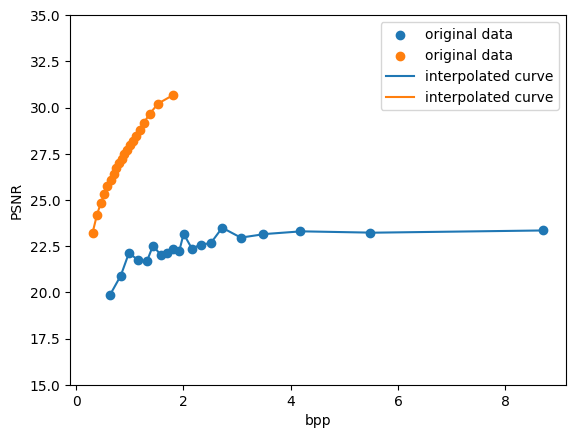

In [28]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Create interpolation function
f2 = interp1d(bpp_finals_jpeg, psnr_finals_jpeg, kind='linear')

f = interp1d(bpp_finals, psnr_finals, kind='linear')


# Create new x values for the function
new_bpp_values = np.linspace(min(bpp_finals), max(bpp_finals), num=1000, endpoint=True)
new_bpp_values2 = np.linspace(min(bpp_finals_jpeg), max(bpp_finals_jpeg), num=1000, endpoint=True)

# Compute the new y values
new_psnr_values = f(new_bpp_values)
new_psnr_values2 = f2(new_bpp_values2)

# Plot the original data points
plt.scatter(bpp_finals, psnr_finals, label='original data')
plt.scatter(bpp_finals_jpeg, psnr_finals_jpeg, label='original data')

# Plot the new smooth curve
plt.plot(new_bpp_values, new_psnr_values, label='interpolated curve')
plt.plot(new_bpp_values2, new_psnr_values2, label='interpolated curve')

plt.ylim([15, 35])  # PSNR range from 10 to 40

plt.legend()
plt.xlabel('bpp')
plt.ylabel('PSNR')
plt.show()


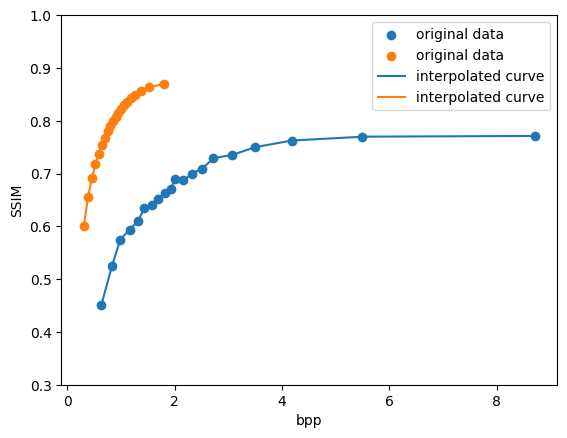

In [30]:
# Create interpolation function
f2 = interp1d(bpp_finals_jpeg, ssim_finals_jpeg, kind='linear')

f = interp1d(bpp_finals, ssim_finals, kind='linear')


# Create new x values for the function
new_bpp_values = np.linspace(min(bpp_finals), max(bpp_finals), num=1000, endpoint=True)
new_bpp_values2 = np.linspace(min(bpp_finals_jpeg), max(bpp_finals_jpeg), num=1000, endpoint=True)

# Compute the new y values
new_ssim_values = f(new_bpp_values)
new_ssim_values2 = f2(new_bpp_values2)

# Plot the original data points
plt.scatter(bpp_finals, ssim_finals, label='original data')
plt.scatter(bpp_finals_jpeg, ssim_finals_jpeg, label='original data')

# Plot the new smooth curve
plt.plot(new_bpp_values, new_ssim_values, label='interpolated curve')
plt.plot(new_bpp_values2, new_ssim_values2, label='interpolated curve')

plt.ylim([0.3, 1])

plt.legend()
plt.xlabel('bpp')
plt.ylabel('SSIM')
plt.show()


In [ ]:
#----------------------------------------------PRINT IMAGES TO SEE THE COMPRESSION PSNR SSIM----------------------------------------------------#
import os

psnr_list = []
ssim_list = []
count = 0
quality =15
epoch=4
model = SystemCNN((180, 180, 1))
model_CompCNN = model.CompCNN()
model_RecCNN = model.RecCNN()
model_CompCNN.load_weights(f'/content/drive/MyDrive/Colab-Notebooks/CNN_weights/comp_weights_q{quality}_epoch{last_epoch}.h5')
model_RecCNN.load_weights(f'/content/drive/MyDrive/Colab-Notebooks/CNN_weights/rec_weights_q{quality}_epoch{last_epoch}.h5')
for step, (x_batch_test) in enumerate(ds_validation):
  #batch of 8,300,300,1
  #print(x_batch_test.shape)
  comp_img = model_CompCNN.predict(x_batch_test)
  jpeg_img = codec2(comp_img,quality)
  final, o_out, o_upscaled_image = model_RecCNN.predict(jpeg_img)
  jpeg_batch = jpegcodec(x_batch_test.numpy(),30)
  #Check the range of the values in jpeg_batch
  #min_val = np.min(jpeg_batch)
  #max_val = np.max(jpeg_batch)
  #print(f"Min: {min_val}, Max: {max_val}")
  for i, j, k in zip(x_batch_test, final, jpeg_batch):
    if count<10:
      print("Original Image")
      plt.imshow(i.numpy().squeeze(), cmap='gray')
      plt.axis("off")
      plt.show()

      print("Predicted Image")
      plt.imshow(j.squeeze(), cmap='gray')
      plt.axis("off")
      plt.show()

      print(psnr(i,j),ssim(i,j))

      print("JPEG Produced Image")
      plt.imshow(k.numpy().squeeze(), cmap='gray')
      plt.axis("off")
      plt.show()


      print(psnr(i,k),ssim(i,k))

    psnr_list.append(psnr(i,j))
    ssim_list.append(ssim(i,j))
    count+=1

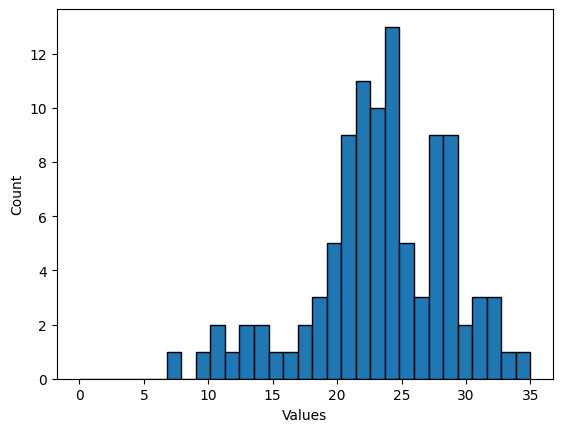

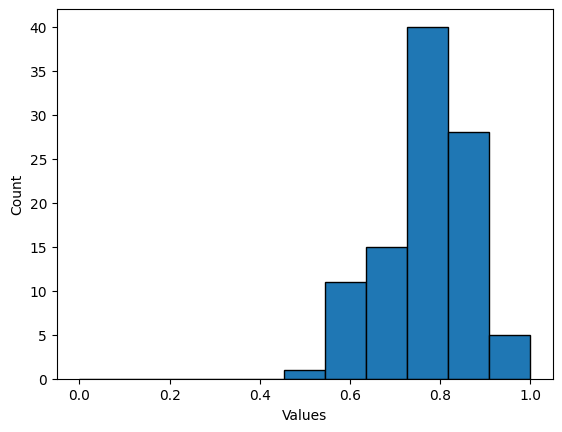

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt

# Create the list of values
values = psnr_list

# Plot the histogram
plt.hist(psnr_list, bins=31, range=(0, 35),edgecolor="black")

# Add axis labels
plt.xlabel('Values')
plt.ylabel('Count')

# Show the plot
plt.show()
plt.savefig('histogram_psnr.png')

# Create the list of values
values = ssim_list

# Plot the histogram
plt.hist(ssim_list, bins=11, range=(0, 1),edgecolor="black")

# Add axis labels
plt.xlabel('Values')
plt.ylabel('Count')

# Show the plot
plt.show()
plt.savefig('histogram_ssim.png')